### Findings:
* Non-normal scaling indeed reduces the ability of the sampler to get samples in certain important parts of the domain
* SETUP: Build a (true, unobserved) $f:x1,x2 \rightarrow y$ such that $pdp(x2, y)$ is negative for $x2 \in \Phi$, where $\Phi$ is part of a typical set of all $x2 \in X2$, but where $pdp(x2,y)$ is positive for $x2 \in \Omega$, where $\Omega$ is an "extremely high" range of x2.
* TEST: if lime is successful, there should exist some kernel width $\delta$ such that $LIME(\delta, x_{2,i}) > 0$ and $LIME(\delta, x_{2,j}) < 0$, where $x_{2,j} \in \Phi$ and $x_{2,i} \in \Omega$
* FINDING: We are able to recover a successful lime, even in the context of highly skewed data. However, only able to recover correct value by searching values of $\delta$
* IMPACT: We need prevant false conclusions as a function of poorly chosen $\delta$.

In [1]:
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

import pandas as pd
import numpy as np
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

229501.781759
966381.406447


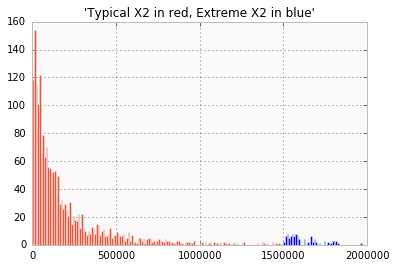

In [6]:
N = 2000
N_extreme = 50
x1 = np.random.gamma(5., 10. , size=N)
x1 = np.array(map(lambda x: x ** 3, x1)).reshape(N, 1)
x2 = np.random.gamma(5., 10. , size=N)
x2 = np.array(map(lambda x: x ** 3, x2)).reshape(N, 1)
X1 = np.concatenate((x1, x2), axis=1)
X2 = X1[:N_extreme]
X2[:, 1] += 1500000
X = np.concatenate((X1, X2), axis=0)

extreme_val = X2[:, 1].min()

extreme_idx = np.where(X[:, 1] > extreme_val)[0]
normal_idx = np.where(X[:, 1] <= extreme_val)[0]


B1 = np.array([1 / 98490., -2 / 98490.])
B2 = np.array([1 / 98490., 10 / 98490.])

y = np.zeros(N_extreme + N)
y[normal_idx] = np.dot(X[normal_idx], B1) + np.random.normal(0, 5, size=len(normal_idx)) > 0
y[extreme_idx] = np.dot(X[extreme_idx], B2) + np.random.normal(0, 5, size=len(extreme_idx)) > 0


print X1.mean()
print X2.mean()

ax = pd.Series(X[normal_idx, 1]).hist(bins = [i* 10000 for i in range(200)])
pd.Series(X[extreme_idx, 1]).hist(bins = [i* 10000 for i in range(200)], ax=ax, color = 'blue')
ax.set_title("'Typical X2 in red, Extreme X2 in blue'")
plt.show()

In [17]:
model = GradientBoostingClassifier(n_estimators=1000, max_depth=5)
model.fit(X, y)

explanation =  LimeTabularExplainer(X, feature_names=['x1','x2'], discretize_continuous=False)
exp, data = explanation.explain_instance(z_obs,model.predict_proba,return_data=True, num_samples=1000)

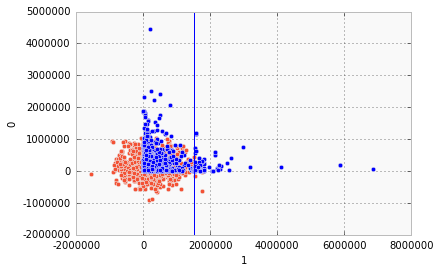

In [19]:
ax = pd.DataFrame(data['data']).plot(kind= 'scatter',x=1, y = 0)
pd.DataFrame(X).plot(ax=ax, kind = 'scatter',x=1, y = 0, color = 'blue')
ax.axvline(extreme_val)

### Find a point with a locally positive relationship far from center

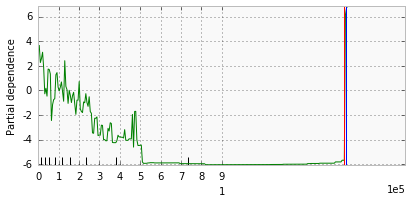

In [11]:
x1_value_with_positive_effect = extreme_val + 10000

import matplotlib.pyplot as plt
from sklearn.ensemble.partial_dependence import plot_partial_dependence
f, [ax] = plot_partial_dependence(model, X, [1], percentiles=(.03, .97), grid_resolution=300) 
ax.set_xticks([j * 100000 for j in range(10)])
ax.axvline(x1_value_with_positive_effect)
ax.axvline(extreme_val, color='red')
plt.show()

In [20]:
idx = np.argmin(abs(X[:, 1] - x1_value_with_positive_effect))
obs = X[idx]

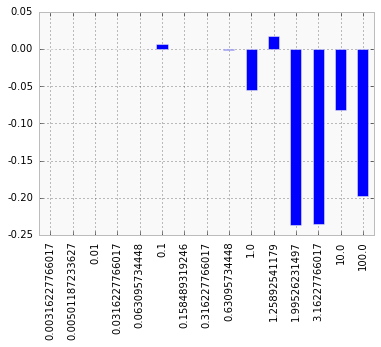

In [25]:
x2_by_kernel = {}
kernel_vals = map(lambda i: 10 ** i, [-2.5, -2.3, -2, -1.5, -1.2, -1, -.8, -.5, -.2, 0, .1,.3,.5, 1, 2])
z_obs = obs.copy()
z_obs[1] = extreme_val
for kernel_width in kernel_vals:
    explanation =  LimeTabularExplainer(X
                                    , feature_names=['x1','x2']
                                    , discretize_continuous=False
                                    , kernel_width = kernel_width
                                   )
    exp, data = explanation.explain_instance(z_obs
                                             ,model.predict_proba
                                             ,return_data=True
                                             , num_samples=50
                                            )    
    
    x2_by_kernel[kernel_width] = dict(exp.as_list())['x2']
    
pd.Series(x2_by_kernel).plot(kind = 'bar')
plt.show()

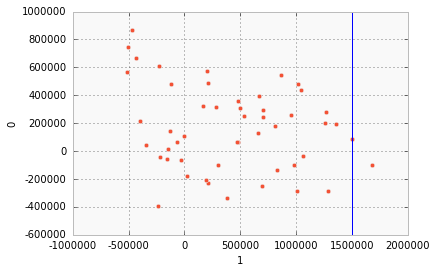

In [26]:
ax = pd.DataFrame(data['inverse']).plot(x=1, y = 0, kind = 'scatter')
ax.axvline(z_obs[1])